## Learning Value Evaluation - Model Free

Today we deal with the task of evaluating a fixed policy $\pi$ in an environment for which we _do not_ have a model.


The only access to the properties of the environment is through the direct experience of the agent, i.e. a set of trajectories $\{ \tau \}$ 

$\tau_i = (S^i_0, A^i_0, R^i_1, S^i_1, A^i_1, R^i_2, \dots S^i_{T^i})$

To evaluate the policy we will exploit two equivalent formulations of the value function. The first is the definition as _"the expected return when starting in s and following the policy $\pi$ thereafter."_

$$
V_\pi(s) = \mathbb{E}_\pi\bigg[ \sum_{t=0}^\infty \gamma^t \, R_{t+1} \, \, \Big| \, \, S_0 = s \bigg] \ .
$$

The second formulation comes from the recursive property of the value function, in the stochastic approximation. The value is _"the expectation value of the sum of the immediate reward plus the discounted value of the successive state, when starting in s and following the policy $\pi$"_. 

$$
V_\pi(s) = \mathbb{E}_{\pi}\bigg[ R_1 + \gamma V_\pi(S_1) \,\, \Big| \,\, S_0 = s, A_0 \sim \pi \bigg] \ .
$$


## An extremely simple _random-walk_ model.

The environment is made by $N$ states on a line. From a state $k$, we have two actions, $L = left$ and $R = right$, which deterministically bring us to the states $k-1$ and $k+1$ respectively. If we exit the system from the left (i.e. we go to state $k=-1$) the game terminates with zero reward. If we exit the system from the right (i.e. we go to state $k=N+1$) the game terminates with reward $r=1$.


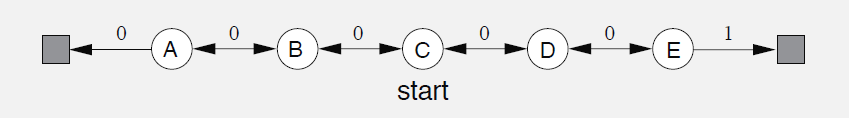

### Q: What is the value of the states for  a _random-walk_ policy?

**Q:** First of all, what is a random-walk policy?

- $\pi(L|s) = ?$
- $\pi(R|s) = ?$

**Q:** What is the real value?
Hint: "Visualize" the Bellman equation and the end points.
$$
        V(k) = \,\,\,\, \pi(L|s) \,\, V(k-1)  \,\,\,\, + \,\,\,\, \pi(R|s) \,\, ( V(k+1) + 1 \delta_{k,N}) 
$$



In [16]:
import numpy as np
class random_walk_env():
    def __init__(self, size=5):
        
        # definition of observables
        self.observation_size = size
        self.observation_space = np.arange(size)

        # definition of the action space
        self.action_space = np.array([-1,1], dtype=int)
        
        # we always start in the middle.
        self.current_state = size//2
        self.done = False

        
    def reset(self):
        # reset the environment to the beginning
        self.current_state = self.observation_size//2
        self.done = False
        
    def step(self, action):
        # Takes action, updates state
        # and gives back information.
        
        assert action in self.action_space, 'Allowed actions are -1 (left) or 1 (right)'
        
        # Update state.
        self.current_state += action
        
        # Check if *done* condition is satisfied.
        # Exit from the left: 0 reward
        if self.current_state == self.observation_space[0]-1:
            reward = 0
            self.done = True
        # Exit from the right: +1 reward
        elif self.current_state == self.observation_space[-1]+1:
            reward = 1
            self.done = True
        else:
            reward = 0        
        return self.current_state, reward, self.done
    
    def render(self):
        # show environment state 
        # just for visual aid!
        pass
    

In [17]:
# Let's try it out.

RW = random_walk_env()
for i in range(40):
    s = RW.current_state
    a = np.random.choice([-1,1],p=[0.5,0.5])
    new_s, r, done = RW.step(a)
    print("s={}, a={}, r={}, s'={}, done? {}".format(s, a, r, new_s, done))
    if done:
       RW.reset() 
       print("\n")

s=2, a=-1, r=0, s'=1, done? False
s=1, a=1, r=0, s'=2, done? False
s=2, a=1, r=0, s'=3, done? False
s=3, a=-1, r=0, s'=2, done? False
s=2, a=-1, r=0, s'=1, done? False
s=1, a=-1, r=0, s'=0, done? False
s=0, a=1, r=0, s'=1, done? False
s=1, a=-1, r=0, s'=0, done? False
s=0, a=1, r=0, s'=1, done? False
s=1, a=1, r=0, s'=2, done? False
s=2, a=1, r=0, s'=3, done? False
s=3, a=-1, r=0, s'=2, done? False
s=2, a=-1, r=0, s'=1, done? False
s=1, a=1, r=0, s'=2, done? False
s=2, a=1, r=0, s'=3, done? False
s=3, a=-1, r=0, s'=2, done? False
s=2, a=1, r=0, s'=3, done? False
s=3, a=-1, r=0, s'=2, done? False
s=2, a=-1, r=0, s'=1, done? False
s=1, a=1, r=0, s'=2, done? False
s=2, a=1, r=0, s'=3, done? False
s=3, a=1, r=0, s'=4, done? False
s=4, a=1, r=1, s'=5, done? True


s=2, a=-1, r=0, s'=1, done? False
s=1, a=-1, r=0, s'=0, done? False
s=0, a=1, r=0, s'=1, done? False
s=1, a=-1, r=0, s'=0, done? False
s=0, a=-1, r=0, s'=-1, done? True


s=2, a=1, r=0, s'=3, done? False
s=3, a=1, r=0, s'=4, done?

## Monte Carlo estimation

The first method of Value estimation for a policy $\pi$ is called first-visit Monte Carlo, and seeks to evaluate the expected value by just plain averaging returns.

$$
V_\pi(s) = \mathbb{E}_\pi\bigg[ \sum_{t=0}^\infty \gamma^t \, R_{t+1} \, \, \Big| \, \, S_0 = s \bigg] \ .
$$

The agent interacts with the environment producing trajectories $\tau$ up to termination.

Afterwards, using the complete trajectory it calculates the returns at each time step $G_t$. The _first time_ that the agent encounter a state $s$ in the trajectory, it stores in memory the corresponding return (it uses only the first time to insure that all returns are independent.)

The values are then calculated by averaging all stored returns for each state.




### First-visit MC method pseudocode

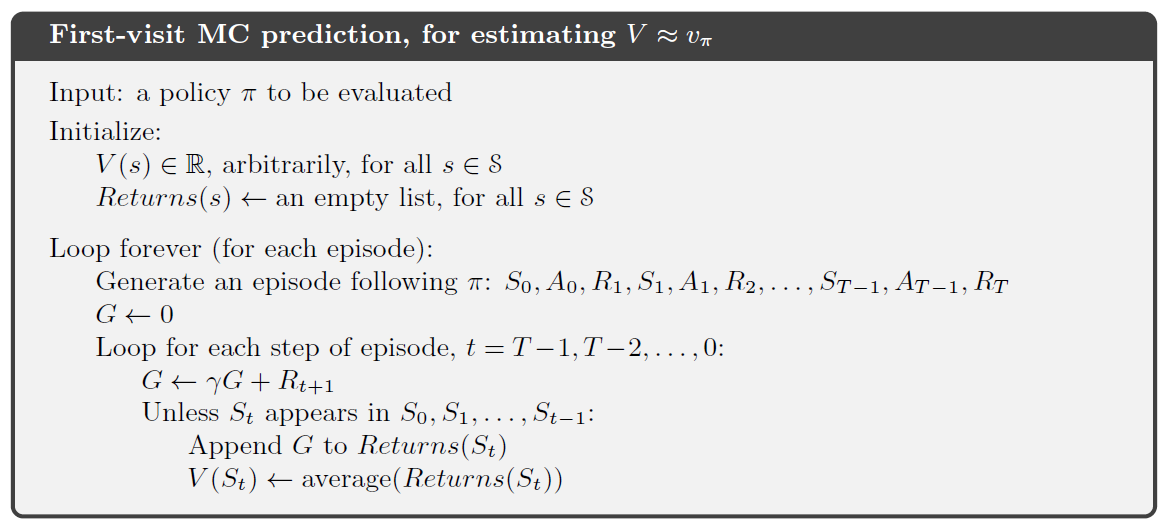



In [18]:
import scipy.signal
import numpy as np

# Ausiliary function
def discount_cumsum(x, discount):
    """
    magic for computing discounted cumulative sums of vectors.
    input:
        vector x,
        [x0,
         x1,
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

## The code for the first visit MC

In [19]:
class first_visit_MC_Evaluation():
    def __init__(self, size=5, gamma=1):
        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.size = size

        # where to save returns
        self.returns = [np.empty(0) for i in range(self.size)]
    
    # -------------------   
    def single_episode_update(self, traj_states, traj_rew):
        """
        Uses a single trajectory to update the values, using first-visit MC.
        """
        visited = np.empty(0)
        
        # calculates the returns for each step: DISCOUNTed CUMulative SUM.
        ret = discount_cumsum(traj_rew, gamma)
        
        
        for t_step, s in enumerate(traj_states):
            
            # ---------------------------------
            # Q : 
            
            if not (s in visited):
                self.returns[s] = np.append(self.returns[s], ret[t_step])
                visited = np.append(visited, s)
        
            # no need to go further: we have first-visited 
            if visited.shape == self.size:
                break
        
    # -------------------
    def estimate_values(self):
        n_obs = self.size
        value = np.zeros(n_obs)
        for s in range(n_obs):
            value[s] = np.mean(self.returns[s])
        return value
                

# Constant Learning-Rate MonteCarlo

To use the _first-visit_ MC we need to store all returns for all visited states.

This is most of the times unfeasible. For this reason, one generally uses a (possibly varying) learning rate. (Here, I will use a constant rate. For convergence, the learning rate must have some properties as defined in class).
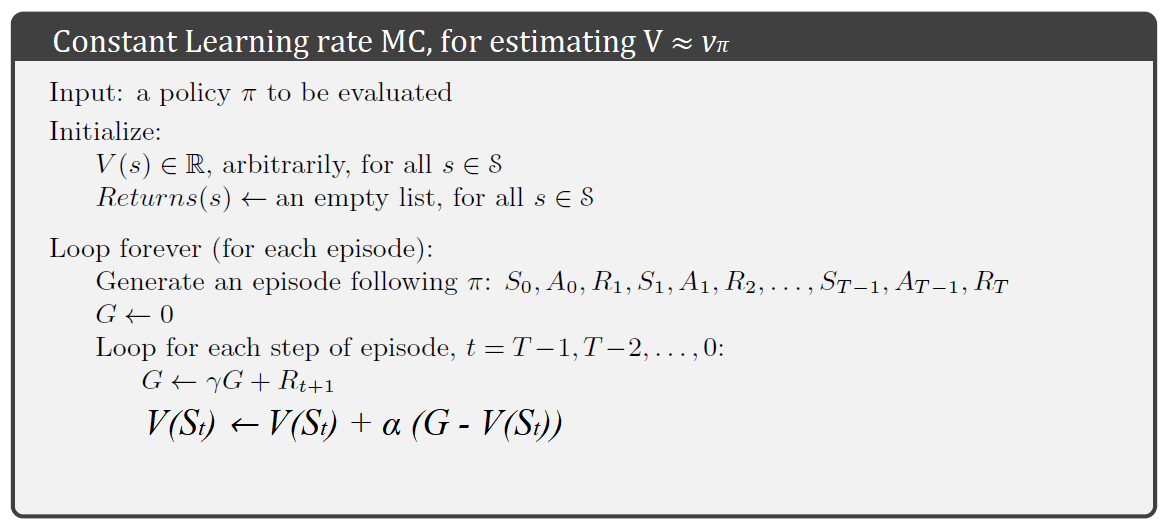

In [20]:
class learning_rate_MC_Evaluation():
    def __init__(self, size=5, gamma=1, lr_v=0.1):
        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.size = size
        # where to save returns
        self.values = np.zeros(self.size)
    
    # -------------------   
    def single_episode_update(self, traj_states, traj_rew):
        """
        Uses a single trajectory to update the values, using constant learning_rate.
        """
        
        # calculates the returns for each step: DISCOUNTed CUMulative SUM.
        ret = discount_cumsum(traj_rew, gamma)
        
        for t_step, s in enumerate(traj_states):
            self.values[s] += lr_v*(ret[t_step]- self.values[s])        
                

# Estimated convergence

We average the mean squared error over 50 different runs for the values calculated after a certain numbers of episodes.

/home/epanizon/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/epanizon/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


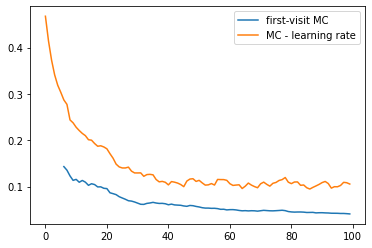

In [21]:
import matplotlib.pyplot as plt

n_episodes = 100
# action space =         [  L,   R]
random_policy = np.array([0.5, 0.5])
# gamma
gamma = 1.0
# learning rate
lr_v = 0.05

# what is the real value?
real_values = [1/6, 2/6, 3/6, 4/6, 5/6]

# error in time
empirical_error = np.empty(0)

# create environment
env = random_walk_env()

empirical_error_MC = np.zeros(n_episodes)
empirical_error_MC2 = np.zeros(n_episodes)

traj_act = np.empty(0)

# number of runs for average errors
n_average = 50

# loop over episodes
for i_av in range(n_average):
    
    # initialize the algorithm
    MC_first_visit = first_visit_MC_Evaluation(env.observation_size, gamma)
    MC_learning_rate = learning_rate_MC_Evaluation(env.observation_size, gamma, lr_v=0.1)
    
    for i in range(n_episodes):
        traj_states = np.empty(0, dtype=int)
        traj_rew = np.empty(0)
        done = False

        env.reset()
        s = env.current_state

        while not done:
            traj_states = np.append(traj_states, s)
            a = np.random.choice(env.action_space, p=random_policy)
            traj_act = np.append(traj_act, a)
            new_s, r, done = env.step(a)
            traj_rew = np.append(traj_rew, r)
            #print(s, a, new_s, r, done)
            s = new_s

        MC_first_visit.single_episode_update(traj_states, traj_rew)
        MC_learning_rate.single_episode_update(traj_states, traj_rew)

        values = MC_first_visit.estimate_values()
        values2 = MC_learning_rate.values

        empirical_error_MC[i] += np.mean(np.sqrt((values-real_values)*(values-real_values))) / n_average
        empirical_error_MC2[i] += np.mean(np.sqrt((values2-real_values)*(values2-real_values))) /n_average
    
    #print(values, values2, empirical_error_MC[-1], empirical_error_MC2[-1]) 
    
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(np.arange(n_episodes), empirical_error_MC, label='first-visit MC')
ax.plot(np.arange(n_episodes), empirical_error_MC2, label='MC - learning rate')
ax.legend()

## Temporal Difference - TD(0)

So far we have used the _definition_ of the return. 
We have an unbiased estimator, but with very large variance, slow convergence and the need to _wait until the end of the episode!_.

However, there is one property of the value function which we have not exploited yet.

$$
    V_\pi(s) = \mathbb{E}_\pi\bigg[ R_{t+1} + \gamma V_\pi(S_{t+1}) \,\, \Big| \,\, S_t = s \bigg] \ .
$$


After just one step, we can define the Temporal Difference error, or TD error, as:
$$
    \delta_{t} = [ R_{t+1} + \gamma V(S_{t+1}) - V(S_t)] \ .
$$
With the condition that

$$
\mathbb{E}_\pi\bigg[ \delta_{t} \,\, \Big| \,\, S_t = s \bigg] = 0\ .
$$

- What is the "meaning" of $\delta_t$? It is the difference between the _experienced reward $R_{t+1}$_ and the _expected reward $\gamma V(S_{t+1}) - V(S_t)$_.

The condition that the the average value of $\delta_t$ should be zero allows us to create the simplest _bootstrapping_ algorithm: the TD(0).

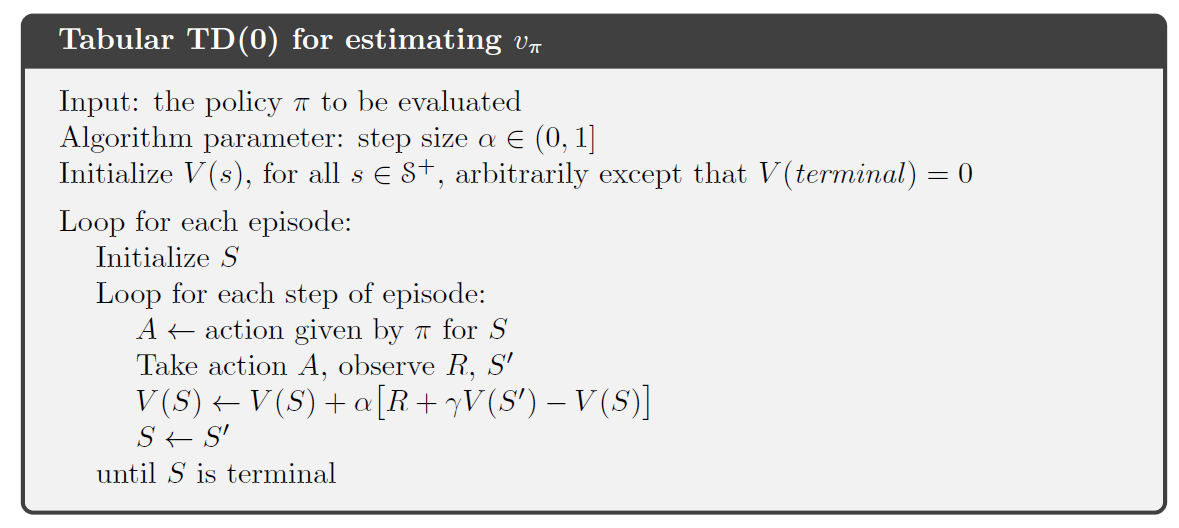



In [22]:
class TD_Zero_Evaluation():
    def __init__(self, size=5, gamma=1, lr_v=0.01):
        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.size = size

        
        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.values = np.zeros(self.size)
    
    # -------------------   
    def single_step_update(self, s, r, new_s, done):
        """
        Uses a single step to update the values, using TD0.
        """
        if done:
            delta = (r + 0 - self.values[s])
        else:
            delta = (r + gamma*self.values[new_s] - self.values[s])
        self.values[s] += self.lr_v * delta
        

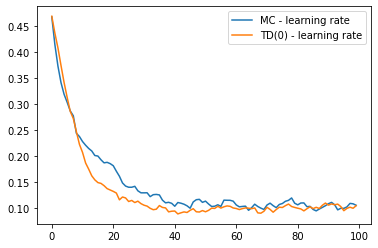

In [23]:
import matplotlib.pyplot as plt

# action space =         [  L,   R]
random_policy = np.array([0.5, 0.5])
# gamma
gamma = 1.0
# learning rate
lr_v = 0.3

# what is the real value?
real_values = [1/6, 2/6, 3/6, 4/6, 5/6]

# error in time
empirical_error_TD0 = np.zeros(n_episodes)

# create environment
env = random_walk_env()


for i_av in range(n_average):
    # initialize the algorithm
    TD_Zero = TD_Zero_Evaluation(env.observation_size, gamma, lr_v)
    # loop over episodes
    for i in range(n_episodes):
        done = False

        env.reset()
        s = env.current_state

        while not done:
            a = np.random.choice(env.action_space, p=random_policy)
            new_s, r, done = env.step(a)
            TD_Zero.single_step_update(s, r, new_s, done)
            s = new_s
        values = TD_Zero.values

        empirical_error_TD0[i] += np.mean(np.sqrt((values-real_values)*(values-real_values)))/n_average
    
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(np.arange(n_episodes), empirical_error_MC2, label='MC - learning rate')
ax.plot(np.arange(n_episodes), empirical_error_TD0, label='TD(0) - learning rate')
ax.legend()

## n-step TD

- **Monte Carlo** methods have to wait until the end of the episode at $T$, and use the complete return $G_t$: 

$$
G_t \, \dot{=} \, R_{t+1} + \gamma R_{t+2} + \gamma^2 R{t+3} + \dots + \gamma^{T-t-1} R_T 
$$

- **One-step Temporal Difference TD(0)** can update every step, without waiting for the end of the episode, using the _one-step_ return $G_{t:t+1}$:

$$
G_{t:t+1} \, \dot{=} \, R_{t+1} + \gamma V_t(S_{t+1})
$$

There is a simple way to combine the strength of the two methods: 
- the **_n-step_ return** $G_{t:t+n}$:

$$
G_{t:t+n} \, \dot{=} \, R_{t+1} + \gamma R_{t+2} + \gamma^2 R{t+3} + \dots + \gamma^{n-1} V_{t+n-1}(S_{t+n})
$$

This method _bootstraps_ previously held information (the value of $V_{t+n-1}(S_{t+n})$) but has less bias then TD(0) since it uses a larger part of the current trajectory. Also, it does not need to wait for the whole episode to finish, since it needs to store only $n$ consecutive steps.

The update is:

$$
V_{t+n-1}(S_t) \, \dot{=} \, V_{t+n-1}(S_t) + \alpha \big( G_{t:t+n} - V_{t+n-1}(S_t) \big)
$$


(If $t + n > T$ (i.e., if the n-step return extendsto or beyond termination), then all the missing terms are taken as zero, and the n-step return defined to be equal to the ordinary full return $G_{t:t+n} \, \dot{=} \, G_t$)

In [24]:
class TD_n_Evaluation():
    def __init__(self, size=5, gamma=1, lr_v=0.01, n=2):
        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.size = size

        # n-step
        self.n = n
        
        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.values = np.zeros(self.size)
    
    # -------------------   
    def n_step_update(self, s_array, r_array, new_s, done):
        """
        Uses n steps to update the values, using TD0.
        Now s_array and r_array contain n-steps of trajectory
        """
        
        ret_n = 0
        for t, r in enumerate(r_array):
            ret_n += r * np.pow(gamma,t)  

        if done:
            delta = (ret_n - self.values[s])
        else:
            delta = (ret_n + np.pow(gamma, n-1) * self.values[new_s] - self.values[s])
            
        self.values[s] += self.lr_v * delta

# Best of both worlds: TD($\lambda$) and eligibility traces

### TD($\lambda$) is elegant...

While _n-step_ returns are a step in the direction of mixing the MC and TD approaches, there is a better, more general way to unite the two methods: the eligibility traces, aka $TD(\lambda)$.

Formally, it uses a return $G^{\lambda}_t $ that includes _all n-step_ returns, weighted by an exponentially decaying factor $\lambda$.

$$
G^{\lambda}_t \sim G_{t:t+1} + \lambda G_{t:t+2} + \lambda^{2} G_{t:t+3} + \lambda^{3} G_{t:t+4} + \dots $$

In a more compact way, we can write: 

$$
G^{\lambda}_t = (1 - \lambda) \sum_{n=1}^{\infty} \lambda^{n-1} G_{t:t+n}
$$

Where $(1 - \lambda)$ is just the proper normalization so that all weight sum to $1$. As before, after the termination $T$, all terms are equal to the complete return, i.e. if $t+n>T$ then  $G_{t:t+n} = G_{t}$.

Notice that we can re-write the term as:

$$
G^{\lambda}_t = (1 - \lambda) \sum_n^{T-t-1} \lambda^{n-1} G_{t:t+n} \, \, + \lambda^{T-t-1} G_t
$$
 
We can see than that $TD(\lambda)$ is equivalent to $TD(0)$ if $\lambda = 0$ or to MC if $\lambda = 1$. 
The update we aim to is of the form:

$$
V(S_t) \, \dot{=} \, V(S_t) + \alpha \big( G^{\lambda}_t - V(S_t) \big)
$$

### ... And eligibility traces are efficient

(cfr: http://incompleteideas.net/book/first/ebook/node72.html)

As defined above, it seems that $TD(\lambda)$ requires the episode to end before it can do any update, just as the $MC$ method. This can be solved with a clever rewritings of the terms and a computational tool called _eligibility traces_ $z_t$. 

To understand the _eligibility traces_, let us consider explicitly what the update should be when we visit state $S_t$. We want to update its value function $V(S_t)$ with a change of the form:

$$ \Delta V(S_t) = \alpha\, ( G_t^{\lambda} - V(S_t) )$$

So if we expand the $G_t^{\lambda}$ return, we have:


$$
\begin{array}{rcll}
 & \frac{1}{\alpha} \Delta V(S_t) &= - V(S_t) &+ G_t^{\lambda}  \\
 &       &=  -V(S_t) &+ (1-\lambda) \lambda^0 [R_{t+1} + \gamma V_t(S_{t+1})]\\
 &       &  &+(1-\lambda) \lambda^1 [R_{t+1} + \gamma R_{t+2} + \gamma^2 V_t(S_{t+2})]\\
 &       &  &+(1-\lambda) \lambda^2 [R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} +  \gamma^3 V_t(S_{t+3})]\\
 &       &  &+\dots
\end{array}
$$

Notice now how we can sum the rewards that appear in the right side of the equations in "columns".
(Recall that $\sum_n \lambda^n = 1/(1-\lambda)$.)

- All terms containing  $R_{t+1}$ sum up to exactly $R_{t+1}$, 
- those with $R_{t+2}$ up to $(\lambda \gamma) R_{t+2}$, 
- those with $R_{t+3}$ to $(\lambda \gamma) ^2 R_{t+3}$ etc. etc. 
- All terms with $V_t(S_{t+k})$ appear twice, with prefactors $ -(\lambda \gamma)^{n}$ and $ +\gamma (\lambda \gamma)^{n-1}$ 

Thus we can rewrite the sum as this:

$$
\begin{array}{rlll}
 & \frac{1}{\alpha} \Delta V(S_t) &= &(\lambda \gamma)^0 [R_{t+1} + \gamma V_t(S_{t+1}) - V_t(S_{t})] \\
 &       & +& (\lambda \gamma)^1 [R_{t+2} + \gamma V_t(S_{t+2}) - V_t(S_{t+1})] \\
 &       & +& (\lambda \gamma)^2 [R_{t+3} + \gamma V_t(S_{t+3}) - V_t(S_{t+2})]  \\
 &      & +&\dots
\end{array}
$$

Notice how the rightenst size is the weighted sum of something very closely related to single TD(0) steps, with a decaying weight $(\lambda \gamma)$. In a sense, each step it suffices to add the new TD step to all previously visited states, but with a decaying weight.

Eligibility traces - in their simplest form - provide an efficient way to approximately do this.
They are a vector of the same dimension of the state space, with weights that at each time $t$ are updated as follow:

$$
    e_t(S) = \left\{
    \begin{array}{cll}
        &\lambda \gamma e_t(S)  & \text{if} \,\,\,\, S \neq S_t \\[2ex]
        &\lambda \gamma e_t(S) + 1   & \text{if} \,\,\,\, S = S_t \\[2ex]
    \end{array}
    \right.
$$

Then at each step the values of _all states_ are modified by the new TD step, not only the currently visited state, each with the weight $e_t(S)$.

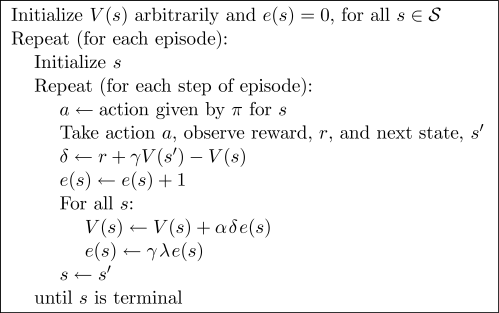

(**Q:** the _on-line_ algorithm shown in the pseudocode is not exactly equivalent to the mathematical formulation above... Where does the difference come from?)


In [25]:
class TD_Lambda_Evaluation():
    def __init__(self, size=5, gamma=1, lam=0.8, lr_v=0.01):
        
        # the discount factor
        self.gamma = gamma
        # the eligibility trace factor lambda
        self.lam = lam
        # size of system
        self.size = size

        
        # the learning rate
        self.lr_v = lr_v
        
        # where to save values
        self.values = np.zeros(self.size)
        # the eligibility traces
        self.et = np.zeros(self.size)
    
    # -------------------   
    def single_step_update(self, s, r, new_s, done):
        """
        Uses a single step to update the values, using TD(lambda).
        """
        self.et[s] += 1
        if done:
            delta = (r + 0 - self.values[s])
        else:
            delta = (r + gamma*self.values[new_s] - self.values[s])
        self.values += self.lr_v * self.et * delta
        self.et *= self.lam * self.gamma
        if done:
            self.et = np.zeros(self.size)
        

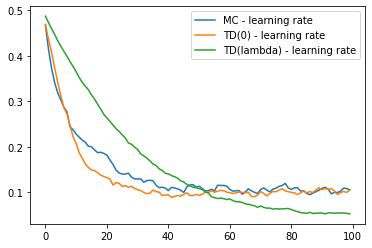

In [26]:
import matplotlib.pyplot as plt

# action space =         [  L,   R]
random_policy = np.array([0.5, 0.5])
# gamma
gamma = 1.0
# learning rate
lr_v = 0.1
# lambda
lam = 0.2
# what is the real value?
real_values = [1/6, 2/6, 3/6, 4/6, 5/6]

# error in time
empirical_error_TDLambda = np.zeros(n_episodes)

# create environment
env = random_walk_env()


for i_av in range(n_average):
    # initialize the algorithm
    TD_Lambda = TD_Lambda_Evaluation(size=env.observation_size, gamma=gamma, lam=lam, lr_v=lr_v)
    # loop over episodes
    for i in range(n_episodes):
        done = False

        env.reset()
        s = env.current_state

        while not done:
            a = np.random.choice(env.action_space, p=random_policy)
            new_s, r, done = env.step(a)
            TD_Lambda.single_step_update(s, r, new_s, done)
            s = new_s
        values = TD_Lambda.values

        empirical_error_TDLambda[i] += np.mean(np.sqrt((values-real_values)*(values-real_values)))/n_average
        
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(np.arange(n_episodes), empirical_error_MC2, label='MC - learning rate')
ax.plot(np.arange(n_episodes), empirical_error_TD0, label='TD(0) - learning rate')
ax.plot(np.arange(n_episodes), empirical_error_TDLambda, label='TD(lambda) - learning rate')
ax.legend()

## Eligibility traces in general

The main difference between the other methods and eligibility traces is this:

- In MC or TD(0), if at time $t$ we visit $S_t$ **_only the relative value $V(S_t)$ will be modified_** by the return approximation (be it $G_t$, or $G_{t:t+1}$ or whatever.)

- With eligibility traces, the return approximation evaluated at time $t$ will modify **_all states, with weigth $e_t$_**, signifying recently visited states, or otherwise "relevant states _eligible_ to change". 

# TD(0) - TD($\lambda$) - TD(1)/MC

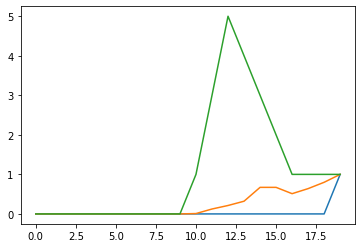

In [27]:
import matplotlib.pyplot as plt

# action space =         [  L,   R]
random_policy = np.array([0.5, 0.5])
# gamma
gamma = 1.0
# learning rate
lr_v = 1

size=20
# create environment
env = random_walk_env(size=20)

n_episodes = 1 
TD_Zero = TD_Lambda_Evaluation(size=env.observation_size, gamma=gamma, lam=0, lr_v=lr_v)
TD_Lambda = TD_Lambda_Evaluation(size=env.observation_size, gamma=gamma, lam=0.8, lr_v=lr_v)
TD_One = TD_Lambda_Evaluation(size=env.observation_size, gamma=gamma, lam=1, lr_v=lr_v)

# ONE SINGLE EPISODE
for i in range(n_episodes):
        done = False

        env.reset()
        s = env.current_state

        while not done:
            a = np.random.choice(env.action_space, p=random_policy)
            new_s, r, done = env.step(a)
            TD_Zero.single_step_update(s, r, new_s, done)
            TD_Lambda.single_step_update(s, r, new_s, done)
            TD_One.single_step_update(s, r, new_s, done)
            s = new_s

    
plt.plot(np.arange(size), TD_Zero.values, np.arange(size), TD_Lambda.values, np.arange(size), TD_One.values)